# PaperPi Structure
Supervisor will loop and poll each plugin for an update. Plugins are all`Plugin()` objects with a `poll` method

When polled `Plugin()` objects respond with a structured list (tuple/dict) with the following information:
* Priority(`int`): 0 (high) -- 10+ (low); plugins with negative values are excluded
* Update Required(`bool`): True update; False do not update

Plugin objects require the following parameters:
* configuration(`dict`) argparse/config.ini style dict
* resolution (this may be pulled from the configuration?)
* name(`str`) human readable name for logging and reference
* update_function(`func`): function that will run and provide updates and status

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import logging
from itertools import cycle
from inspect import getfullargspec
from importlib import import_module
from time import sleep



In [79]:
import constants
from epdlib import Screen
from epdlib.Screen import Update
from library.CacheFiles import CacheFiles
from library.Plugin import Plugin
from library.InterruptHandler import InterruptHandler

In [47]:
logging.basicConfig(level=logging.INFO)


In [48]:
logging.root.setLevel('DEBUG')

In [64]:
config = {
    'main': {
        'resolution': (500, 400),
        'splash': True
    },
    'Plugin: Clock': {
        'layout': 'layout',
        'plugin': 'basic_clock',
        'refresh_rate': 30,
        'min_display_time': 10,
        'max_priority': 1
    },
    'Plugin: Word Clock': {
        'layout': 'word_clock',
        'plugin': 'word_clock',
        'refresh_rate': 30,
        'min_display_time': 10,
        'max_priority': 1,
    },
    'Plugin: Decimal Binary Clock': {
        'layout': 'dec_binary_clock',
        'plugin': 'dec_binary_clock',
        'refresh_rate': 30,
        'min_display_time': 10,
        'max_priority': 1,
    },
    'Plugin: LMS MacPlay': {
        'layout': 'twoColumn',
        'plugin': 'lms_client',
        'refresh_rate': 5,
        'player_name': 'MacPlay',
        'min_display_time': 15,
        'max_priority': 0,
        'idle_timeout': 10
    },
    'Plugin: LibreSpot': {
        'layout': 'twoColumn',
        'plugin': 'librespot_client',
        'refresh_rate': 10,
        'player_name': 'SpoCon-Spotify',
        'idle_timeout': 15,
        'max_priority': 0,
    }
}


In [84]:
# logging.root.setLevel('DEBUG')
logging.root.setLevel('INFO')

In [85]:
splash_config = {
    'name': 'Splash Screen',
    'layout': splash_screen.layout.layout,
    'update_function': splash_screen.update_function,
    'resolution': config['main']['resolution']
}

In [86]:

if 'splash' in config['main']:
    if config['main']['splash']:
        from plugins.splash_screen import splash_screen
        splash = Plugin(**splash_config)
else:
    splash = None

INFO:root:set text block: app_name
INFO:root:TextBlock created
INFO:root:set text block: version
INFO:root:TextBlock created
INFO:root:set text block: url
INFO:root:TextBlock created


In [90]:
cache = CacheFiles(path_prefix=constants.app_name)
# get the expected key-word args from the Plugin() spec
spec_kwargs = getfullargspec(Plugin).args

plugins = []

for section, values in config.items():
    # ignore the other sections
    if section.startswith('Plugin:'):
        logging.info(f'[[ {section} ]]')

        my_config = {}
        # add all the spec_kwargs from the config
        plugin_kwargs = {}
        for key, val in values.items():
            if key in spec_kwargs:
                my_config[key] = val
            else:
                # add everything that is not one of the spec_kwargs to this dict
                plugin_kwargs[key] = val
        
        # populate the kwargs my_config dict that will be passed to the Plugin() object
        my_config['name'] = section
        my_config['resolution'] = config['main']['resolution']
        my_config['config'] = plugin_kwargs
        my_config['cache'] = cache
        try:
            module = import_module(f'plugins.{values["plugin"]}')
            my_config['update_function'] = module.update_function
            my_config['layout'] = getattr(module.layout, values['layout'])
        except KeyError as e:
            ## FIX ME -- do a graceful exit here?
            logging.info('no module specified; skipping update_function and layout')
        my_plugin = Plugin(**my_config)
        try:
            my_plugin.update()
        except AttributeError:
            ## FIX ME -- do a graceful exit here?
            logging.info('skipping update due to missing update_function')
        logging.info(f'appending plugin')
        plugins.append(my_plugin)

INFO:root:[[ Plugin: Clock ]]
INFO:root:set text block: digit_time
INFO:root:TextBlock created
INFO:root:updating blocks
INFO:root:appending plugin
INFO:root:[[ Plugin: Word Clock ]]
INFO:root:set text block: wordtime
INFO:root:TextBlock created
INFO:root:set text block: time
INFO:root:TextBlock created
INFO:root:updating blocks
INFO:root:appending plugin
INFO:root:[[ Plugin: Decimal Binary Clock ]]
INFO:root:set image block bin_img
INFO:root:Image Block Created
INFO:root:set text block: time
INFO:root:TextBlock created
INFO:root:updating blocks
INFO:root:appending plugin
INFO:root:[[ Plugin: LMS MacPlay ]]
INFO:root:set image block coverart
INFO:root:Image Block Created
INFO:root:set text block: title
INFO:root:TextBlock created
INFO:root:set text block: artist
INFO:root:TextBlock created
INFO:root:set text block: album
INFO:root:TextBlock created
INFO:root:updating blocks
ERROR:root:failed to update due to error: local variable 'im' referenced before assignment
INFO:root:appending pl

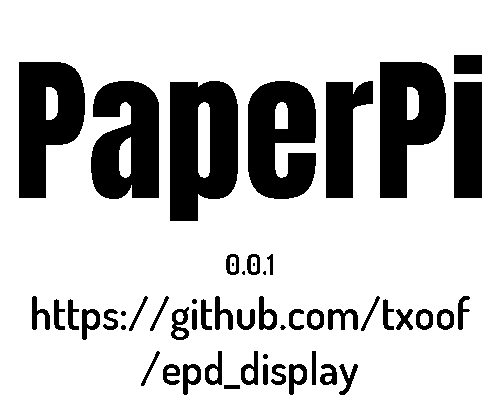

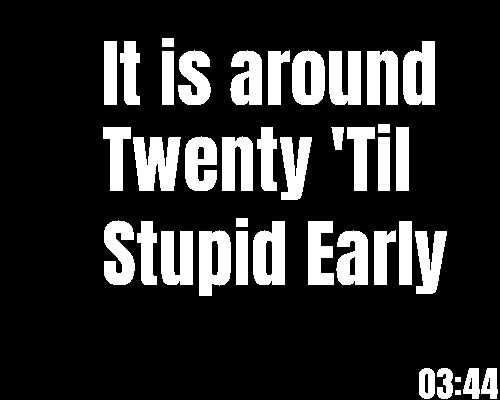

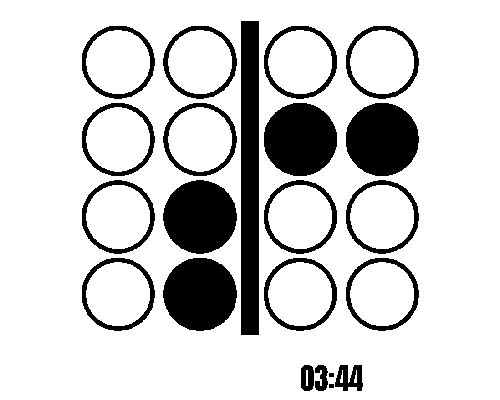

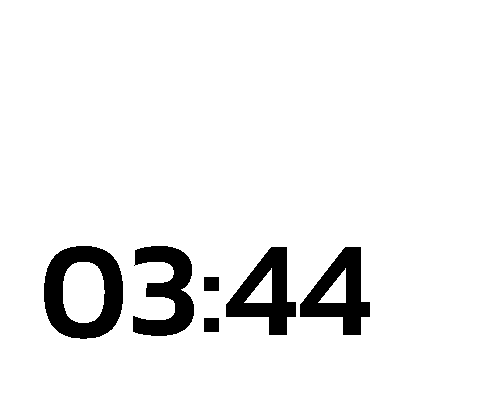

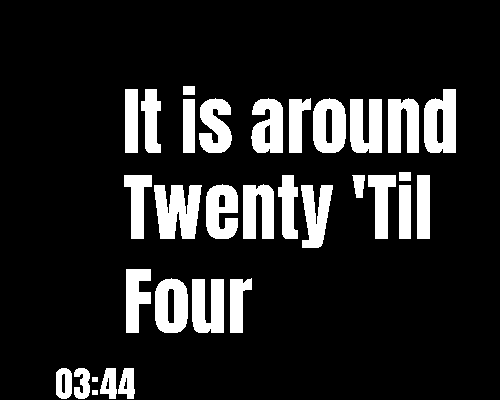

cleanup here


In [92]:
## FIX ME Remove this import only for testing in Jupyter
from IPython.display import display
## FIX ME

logging.root.setLevel('WARNING')

if splash:
    splash.update(constants.app_name, constants.version, constants.url)
    display(splash.image)

# use itertools cycle to move between list elements
plugin_cycle = cycle(plugins)
plugin_is_active = False
# current plugin for display
this_plugin = next(plugin_cycle)
# track time plugin is displayed for
this_plugin_timer = Update()
max_priority = -1
# each plugin generates a unique hash whenever it is updated
this_hash = ''

# display_loop_sighandler = SignalHandler()



with InterruptHandler() as h:
    while True:    
        if h.interrupted:
            logging.info('caught interrupt -- stoping execution')
            break
        logging.info('updating plugins')
        priority_list = []

        for plugin in plugins:
            logging.debug(f'[[ {plugin.name} ]]')
            plugin.update()
            # record the priority of all active plugins (priority < 0 is considered inactive)
            if plugin.priority >= 0:
                priority_list.append(plugin.priority)

        # priority increases as it approaches 0; negative priorities are considered inactive        
        max_priority = min(priority_list)
        logging.info(f'current maximum priority: {max_priority}')

        logging.info(f'displaying plugins')
        logging.info(f'[[ {this_plugin.name} ]]')

        if this_plugin_timer.last_updated > this_plugin.min_display_time:
            logging.info(f'this plugin\'s display timer expired; switching plugin')
            plugin_is_active = False

            while not plugin_is_active:
                this_plugin = next(plugin_cycle)
                logging.debug(f'checking priority of {plugin.name}')
                if this_plugin.priority >= 0 and this_plugin.priority <= max_priority:
                    plugin_is_active = True
                else:
                    logging.debug(f'priority is too low: {this_plugin.priority}, max_priority: {max_priority}')
                    plugin_is_active = False                
                    ## this would be a good place to track failed attempts to find a plugin with appropriate
                    ## display value

            logging.debug(f'preparing to display {this_plugin.name}')

            if this_hash != this_plugin.hash:
                logging.debug('plugin image has refreshed -- refreshing screen')
                this_hash = this_plugin.hash
                ## FIX ME! this is where the epdlib.Screen belongs
                display(this_plugin.image)
            else:
                logging.debug('plugin image has not refreshed -- skiping screen refresh')
            this_plugin_timer.update()

        ## FIX ME -- find a better way to sleep here?
        sleep(1)
print('cleanup here')
cache.cleanup()